In [1]:
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='serif')
import seaborn as sns

from tqdm import tqdm

import pandas as pd

import torch
import torch.distributions as dist

import bruges
from bruges.rockphysics.fluidsub import vels as vels_gassmann
from bruges.rockphysics.bounds import voigt_bound

from geobed import BED_discrete
from geobed.fwd_collection.avo import *

from utils import *

In [3]:
# nuisance parameters

a_1_mean = torch.tensor([2270.0]) # m/s from Ghosh2020
a_1_std = torch.tensor([10.0])    # m/s filler value

b_1_mean = torch.tensor([854.0])  # m/s from Ghosh2020
b_1_std  = torch.tensor([10.0])   # m/s filler value

p_1_mean = torch.tensor([2100.0]) # kg/m3 from Ghosh2020
p_1_std  = torch.tensor([10.0])   # kg/m3 filler value

d_mean = torch.tensor([1000.0])   # m from Dupuy2017
d_std  = torch.tensor([50.0])     # m filler value

# Grain properties

# =================== carefull uncertainties are larger than reported in Ghosh2020 ===================

K_grain_mean = torch.tensor([39.3])*1e9              # Pa from Ghosh2020
K_grain_std  = torch.tensor([3.6/100])*K_grain_mean  # Pa from Ghosh2020

G_grain_mean = torch.tensor([44.8])*1e9              # Pa from Ghosh2020
G_grain_std  = torch.tensor([1.8/100])*G_grain_mean  # Pa from Ghosh2020

rho_grain_mean = torch.tensor([2664.0])                  # kg/m3 from Ghosh2020
rho_grain_std  = torch.tensor([0.1/100])*rho_grain_mean  # kg/m3 from Ghosh2020


# Frame properties

K_frame_mean = torch.tensor([2.56])*1e9                 # Pa from Ghosh2020
K_frame_std  = torch.tensor([3.0/100])*K_frame_mean     # Pa from Ghosh2020

G_frame_mean = torch.tensor([8.5])*1e9                  # Pa from Ghosh2020
G_frame_std  = torch.tensor([3.0/100])*G_frame_mean     # Pa from Ghosh2020

k_frame_mean = torch.tensor([2e-12])                    # m2 from Ghosh2020
k_frame_std  = torch.tensor([75.0/100])*k_frame_mean    # m2 from Ghosh2020

m_frame_mean = torch.tensor([1.0])                      # from Ghosh2020
m_frame_std  = torch.tensor([25.0/100])*m_frame_mean    # from Ghosh2020

porosity_mean = torch.tensor([0.37])                    # from Ghosh2020
porosity_std  = torch.tensor([6.75/100])*porosity_mean  # from Ghosh2020

# Brine properties

K_brine_mean = torch.tensor([2.31])*1e9                  # Pa from Ghosh2020
K_brine_std  = torch.tensor([3.24/100])*K_brine_mean     # Pa from Ghosh2020

rho_brine_mean = torch.tensor([1030.0])                  # kg/m3 from Ghosh2020
rho_brine_std  = torch.tensor([1.94/100])*rho_brine_mean # kg/m3 from Ghosh2020

mu_brine_mean = torch.tensor([0.00069])                  # Pa*s from Ghosh2020
mu_brine_std  = torch.tensor([1.5/100])*mu_brine_mean    # Pa*s from Ghosh2020

# CO2 properties

K_co2_mean = torch.tensor([0.08])*1e9                    # Pa from Ghosh2020
K_co2_std  = torch.tensor([53.0/100])*K_co2_mean         # Pa from Ghosh2020

rho_co2_mean = torch.tensor([700.0])                     # kg/m3 from Ghosh2020
rho_co2_std  = torch.tensor([11.0/100])*rho_co2_mean     # kg/m3 from Ghosh2020

mu_co2_mean = torch.tensor([0.000006])                   # Pa*s from Ghosh2020
mu_co2_std  = torch.tensor([17.0/100])*mu_co2_mean       # Pa*s from Ghosh2020
    
prior_table = pd.DataFrame(
    data=[
        [a_1_mean.item(), b_1_mean.item(), p_1_mean.item(), d_mean.item(), K_grain_mean.item(), G_grain_mean.item(), rho_grain_mean.item(), K_frame_mean.item(), G_frame_mean.item(), k_frame_mean.item(), m_frame_mean.item(), porosity_mean.item(), K_brine_mean.item(), rho_brine_mean.item(), mu_brine_mean.item(), K_co2_mean.item(), rho_co2_mean.item(), mu_co2_mean.item()],
        [a_1_std.item(), b_1_std.item(), p_1_std.item(), d_std.item(), K_grain_std.item(), G_grain_std.item(), rho_grain_std.item(), K_frame_std.item(), G_frame_std.item(), k_frame_std.item(), m_frame_std.item(), porosity_std.item(), K_brine_std.item(), rho_brine_std.item(), mu_brine_std.item(), K_co2_std.item(), rho_co2_std.item(), mu_co2_std.item()]
    ],
    index=['mean', 'std'],
    columns=[r'$\alpha_1$', r'$\beta_1$', r'$\rho_1$', r'$d$', r'$K_{grain}$', r'$G_{grain}$', r'$\rho_{grain}$', r'$K_{frame}$', r'$G_{frame}$', r'$k_{frame}$', r'$m_{frame}$', r'$\phi$', r'$K_{brine}$', r'$\rho_{brine}$', r'$\mu_{brine}$', r'$K_{co2}$', r'$\rho_{co2}$', r'$\mu_{co2}$']
)

In [4]:
latex_table = prior_table.T

for i in latex_table.columns:
    latex_table['value'] = latex_table['mean'].round(0).astype(int).astype(str) + "±" + latex_table['std'].round(0).astype(int).astype(str)
latex_table = latex_table.drop(['mean', 'std'], axis=1)
# display(latex_table)

# print(latex_table.style.to_latex(
#      hrules=True, column_format="rr",
# ))


In [5]:
name_to_index = {
    'alpha_1': 0,
    'beta_1': 1,
    'rho_1': 2,
    'd': 3,
    'K_grain': 4,
    'G_grain': 5,
    'rho_grain': 6,
    'K_frame': 7,
    'G_frame': 8,
    'k_frame': 9,
    'm_frame': 10,
    'phi': 11,
    'K_brine': 12,
    'rho_brine': 13,
    'mu_brine': 14,
    'K_co2': 15,
    'rho_co2': 16,
    'mu_co2': 17
}

In [6]:
nuisance_dist = dist.Independent(
    dist.Normal(
        torch.cat([a_1_mean, b_1_mean, p_1_mean, d_mean, K_grain_mean, G_grain_mean, rho_grain_mean, K_frame_mean, G_frame_mean, k_frame_mean, m_frame_mean, porosity_mean, K_brine_mean, rho_brine_mean, mu_brine_mean, K_co2_mean, rho_co2_mean, mu_co2_mean]),
        torch.cat([a_1_std, b_1_std, p_1_std, d_std, K_grain_std, G_grain_std, rho_grain_std, K_frame_std, G_frame_std, k_frame_std, m_frame_std, porosity_std, K_brine_std, rho_brine_std, mu_brine_std, K_co2_std, rho_co2_std, mu_co2_std])
    ),
    1)

In [7]:
# prior parameter

co2_saturations_min = torch.tensor([0.0])
co2_saturations_max = torch.tensor([1.0])

co2_saturations_prior_dist = dist.Independent(dist.Uniform(co2_saturations_min, co2_saturations_max),1)

In [8]:
def get_compute_samples(co2_saturations_prior_samples, nuisance_samples):
    d_nuisance_samples = nuisance_samples[:, name_to_index['d']]

    vp_1_nuisance_samples = nuisance_samples[:, name_to_index['alpha_1']]
    vs_1_nuisance_samples = nuisance_samples[:, name_to_index['beta_1']]
    rho_1_nuisance_samples = nuisance_samples[:, name_to_index['rho_1']]

    K_dry_nuisance_samples = nuisance_samples[:, name_to_index['K_frame']]
    G_dry_nuisance_samples = nuisance_samples[:, name_to_index['G_frame']]

    K_grain_nuisance_samples = nuisance_samples[:, name_to_index['K_grain']]
    G_grain_nuisance_samples = nuisance_samples[:, name_to_index['G_grain']]
    rho_grain_nuisance_samples = nuisance_samples[:, name_to_index['rho_grain']]

    K_brine_nuisance_samples = nuisance_samples[:, name_to_index['K_brine']]
    rho_brine_nuisance_samples = nuisance_samples[:,name_to_index['rho_brine']]

    K_co2_nuisance_samples = nuisance_samples[:, name_to_index['K_co2']]
    rho_co2_nuisance_samples = nuisance_samples[:, name_to_index['rho_co2']]

    porosity_nuisance_samples = nuisance_samples[:, name_to_index['phi']]
    
    water_saturation = 1-co2_saturations_prior_samples

    # voigt_bound
    # From: https://code.agilescientific.com/bruges/_modules/bruges/rockphysics/bounds.html#voigt_bound
    # The upper bound on the effective elastic modulus, mv of a
    #  mixture of N material phases. This is defined at the arithmetic
    #  average of the constituents.

    K_f_nuisance_samples = K_brine_nuisance_samples*water_saturation[:, 0] + K_co2_nuisance_samples*co2_saturations_prior_samples[:, 0]
    rho_f_nuisance_samples = rho_brine_nuisance_samples*water_saturation[:, 0] + rho_co2_nuisance_samples*co2_saturations_prior_samples[:, 0]

    # alternative reuss_bound
    # The lower bound on the effective elastic modulus of a
    # mixture of N material phases. This is defined at the harmonic
    # average of the constituents. Same as Wood's equation for homogeneous mixed fluids.
    
    vp_2_nuisance_samples, vs_2_nuisance_samples, rho_2_nuisance_samples, _ = vels_gassmann(
        Kdry=K_dry_nuisance_samples, 
        Gdry=G_dry_nuisance_samples,
        K0=K_grain_nuisance_samples,
        D0=rho_grain_nuisance_samples,
        Kf=K_f_nuisance_samples,
        Df=rho_f_nuisance_samples,
        phi=porosity_nuisance_samples,
        )
    
    vp_2_nuisance_samples, vs_2_nuisance_samples, rho_2_nuisance_samples, _ = vels_gassmann(
    Kdry=K_dry_nuisance_samples, 
    Gdry=G_dry_nuisance_samples,
    K0=K_grain_nuisance_samples,
    D0=rho_grain_nuisance_samples,
    Kf=K_f_nuisance_samples,
    Df=rho_f_nuisance_samples,
    phi=porosity_nuisance_samples,
    )

    fig, ax = plt.subplots(1,1,figsize=(10,5))

    ax.hist(vp_2_nuisance_samples[:int(1e4)], bins=50, density=True, color='k', alpha=0.5, label='vp')
    ax.hist(vs_2_nuisance_samples[:int(1e4)], bins=50, density=True, color='b', alpha=0.5, label='vs')

    ax.legend()

    plt.show()
    
    prior_samples_computation = torch.cat([
        d_nuisance_samples.unsqueeze(1),
        vp_1_nuisance_samples.unsqueeze(1),
        vp_2_nuisance_samples.unsqueeze(1),
        vs_1_nuisance_samples.unsqueeze(1),
        vs_2_nuisance_samples.unsqueeze(1),
        rho_1_nuisance_samples.unsqueeze(1),
        rho_2_nuisance_samples.unsqueeze(1),
        ], dim=1
    ).T.unsqueeze(2).swapaxes(0,1)
    
    return prior_samples_computation

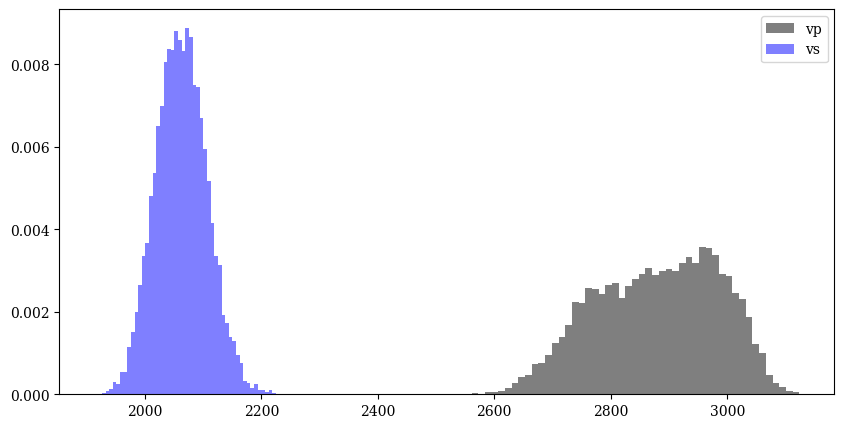

torch.Size([100000, 7, 1])


In [9]:
n_prior_samples = int(1e5)

torch.manual_seed(0)
nuisance_samples = nuisance_dist.sample((n_prior_samples,))
co2_saturations_prior_samples = co2_saturations_prior_dist.sample((n_prior_samples,))

prior_samples_computation = get_compute_samples(co2_saturations_prior_samples, nuisance_samples)

print(prior_samples_computation.shape)

In [10]:
from geobed.fwd_collection import zoeppritz_solver, zoeppritz_solver_rpp

In [11]:
def forward_function(offset, params):
    
    offset = offset[None, :].T
    params = params.swapaxes(0,1)
    
    theta_1 = torch.atan( offset / (2 * params[0]) )
        
    return zoeppritz_solver_rpp(theta_1, params[1], params[2], params[3], params[4], params[5], params[6]).swapaxes(-2,-1)

In [12]:
n_design_points = 100
design_names = [str(i) for i in range(n_design_points)]
offsets      = torch.linspace(100.0, 4000.0, n_design_points)

design_dicts = {}

filename_core = 'interrogation_design/interrogation_design_uniform_co2_question_90'
filename = f"data/interrogation_design/interrogation_design_uniform_co2_{n_prior_samples}_{n_design_points}.h5"

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'offset': offsets[i], 'file': filename, 'dataset': 'data', 'cost': 1.0,}

In [13]:
print(prior_samples_computation.shape)

torch.Size([100000, 7, 1])


In [14]:
prior_samples_computation = generate_lookup_table(
    filename,
    prior_samples_computation,
    offsets,
    forward_function,
    transpose_order=(2, 0, 1),
    n_parallel = 20)

loading lookup table from file


In [15]:
def data_likelihood(samples, **kwargs):

    std_data = 0.05
    
    data_likelihood = dist.Independent(dist.Normal(samples, torch.tensor(std_data)), 1)
    
    return data_likelihood

In [16]:
prior_samples_computation.shape

torch.Size([100000, 7, 1])

In [17]:
from geobed import BED_discrete

BED_class = BED_discrete(design_dicts, data_likelihood, prior_samples=co2_saturations_prior_samples,
                         design2data='lookup_1to1_fast')

No prior distribution given. Variational posterior will only be accurate up to a constant.
                   This is fine for the optimisation but just a heads up.
No prior distribution defined. Setting prior entropy to 0. This has no effect on the design optimisation.


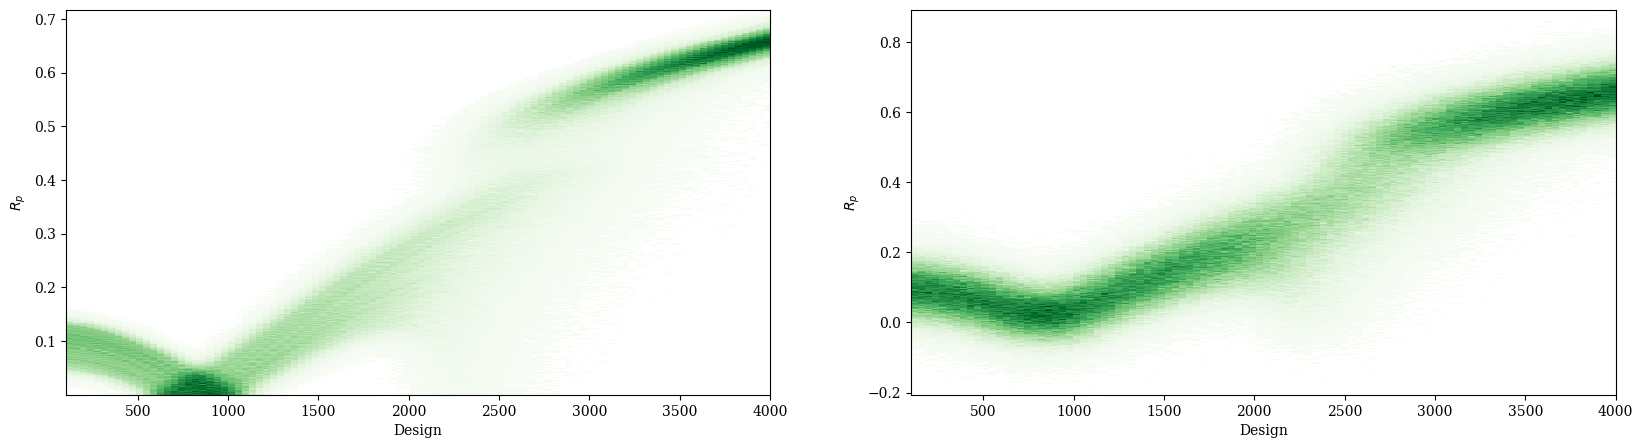

In [18]:
n_visual = int(1e4)

clean_samples = BED_class.get_forward_samples(   design_names, n_samples=n_visual)
noisy_samples = BED_class.get_likelihood_samples(design_names, n_samples=n_visual)

offsets = torch.tensor([d['offset'] for d in design_dicts.values()])

fig = plt.figure(figsize=(20, 5))
ax_dict = fig.subplot_mosaic('''ab''')

ax_dict['a'].hist2d(offsets.expand(n_visual, -1).flatten().numpy(), clean_samples.flatten().numpy(),
                    bins=[n_design_points, 400], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(offsets.expand(n_visual, -1).flatten().numpy(), noisy_samples.flatten().numpy(),
                    bins=[n_design_points, 400], cmap='Greens', cmin=1)
    
ax_dict['a'].set(xlabel='Design', ylabel=r'$R_p$')
ax_dict['b'].set(xlabel='Design', ylabel=r'$R_p$')
                
plt.show()

In [19]:
from torch import Tensor, LongTensor, Size
from torch.distributions import *

from zuko.nn import MLP
from zuko.flows import Parameters

class BM(torch.nn.Module):
    def __init__(
        self,
        features: int,
        context: int = 0,
        **kwargs,
    ):
        super().__init__()

        shapes = [
            (features,),  # probabilities
        ]

        self.shapes = list(map(Size, shapes))
        self.sizes = [s.numel() for s in self.shapes]
       
        if context > 0:
            self.hyper = MLP(context, sum(self.sizes), **kwargs)
        else:
            self.phi = Parameters(torch.randn(*s) for s in shapes)

    def forward(self, y: Tensor = None) -> Distribution:
        if y is None:
            phi = self.phi
        else:
            phi = self.hyper(y)

        probs = torch.nn.Sigmoid()(phi)

        return Independent(Bernoulli(probs=probs), 1)

In [20]:
class BM_guide(torch.nn.Module):
    def __init__(self, model_samples, data_samples, **kwargs):
        super().__init__()
        torch.manual_seed(0)
        self.data_mean = torch.mean(data_samples, dim=0)
        self.data_std = torch.std(data_samples, dim=0)
        data_features = data_samples.shape[-1]
        
        model_features = model_samples.shape[-1]
        
        self.base = BM(features=model_features, context=data_features, **kwargs)
       
    def forward(self, d=None):
                
        d = ((d-self.data_mean)/self.data_std).detach()
                    
        if d is None:
            base = self.base(d)
        else:
            base = self.base(d).expand(d.shape[:-1])

        return base
        
    def log_prob(self, m, d):
        
        out = self.forward(d).log_prob(m)
                
        return out
    
    def sample(self, d, n_samples):
        
        shape = torch.Size([n_samples])
        return self.forward(d).sample(shape).squeeze(0)

In [21]:
def interrogation_mapping(co2_saturations):
    descision_boundary = 0.9
    return torch.where(co2_saturations < descision_boundary, torch.tensor([1.0]), torch.tensor([0.0]))

[]

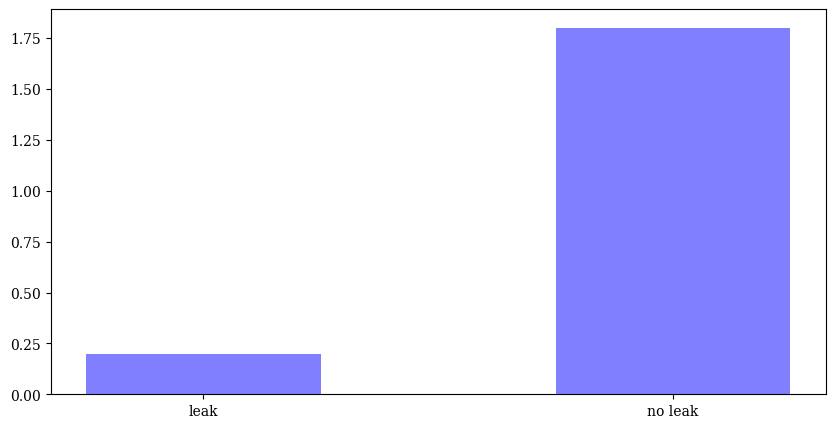

In [22]:
n_test_samples = 1000

reservoir_leaking_test= interrogation_mapping(co2_saturations_prior_dist.sample([n_test_samples,]))

fig, ax = plt.subplots(figsize=(10, 5))

n_bins = 2
ax.hist(reservoir_leaking_test.numpy(), bins=n_bins, density=True, label='prior', alpha=0.5, color='blue', align='mid', rwidth=0.5)
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(['leak', 'no leak'])
 
plt.plot()

In [23]:
reservoir_leaking_test = interrogation_mapping(BED_class.prior_samples[:1000])
data_test              = BED_class.get_likelihood_samples(design_names, n_samples=1000)

In [24]:
test_guide = BM_guide(reservoir_leaking_test, data_test)

In [25]:
out_test = test_guide.log_prob(reservoir_leaking_test[:2], data_test[:2])

print(out_test)

tensor([-0.6515, -0.7596], grad_fn=<SumBackward1>)


10 6 2


Epoch 0/0, Loss: 0.000:   0%|          | 0/6 [00:00<?, ?it/s]

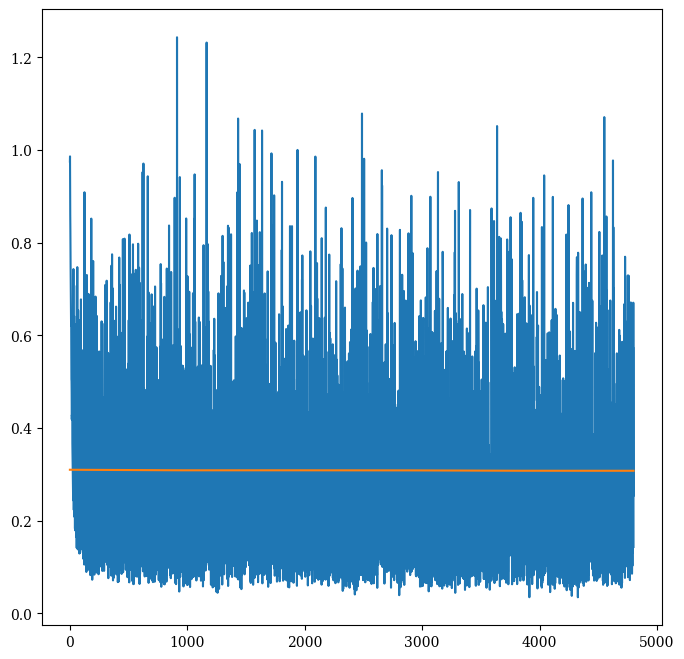

var_post_eig:  tensor(-0.3079)


In [26]:
T = int(1e4)

N = int(T * 0.2)
M = int(T * 0.8)

n_grad_steps = 5000

def n_batch_schedule(M, **kwargs):
    return 10

def n_epochs_schedule(M, n_batch, **kwargs):
    return max(min(100, (n_grad_steps*n_batch)//(M)), 4)

def scheduler_step_size_schedule(n_epochs, **kwargs):
    return n_epochs//3


n_batch = n_batch_schedule(**{'M':M})
n_epochs = n_epochs_schedule(**{'M':M, 'n_batch':n_batch})
step_size = scheduler_step_size_schedule(**{'n_epochs':n_epochs})
print(n_batch, n_epochs, step_size)

# design = ['30', '20', '10', '40']
design = ['0',]

var_post_eig, var_post_info = BED_class.calculate_eig(
    design=design,
    method='variational_posterior',
    method_kwargs=
    {'guide': BM_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'hidden_features':[20, 20], 'normalize':True,},
     'n_batch': n_batch_schedule,
     'n_epochs': n_epochs_schedule,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-3},
     'scheduler': torch.optim.lr_scheduler.StepLR,
     'scheduler_kwargs': {'step_size':scheduler_step_size_schedule, 'gamma':0.3},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     'progress_bar': True,
     'interrogation_mapping': interrogation_mapping, 
     }
)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(np.linspace(0, n_epochs*(M//n_batch), len(var_post_info['train_loss'])),
        var_post_info['train_loss'], label='train loss')
        
ax.plot(np.linspace(0, n_epochs*(M//n_batch), len(var_post_info['test_loss'])),
        var_post_info['test_loss'], label='test loss')

plt.show()

print('var_post_eig: ', var_post_eig)

[]

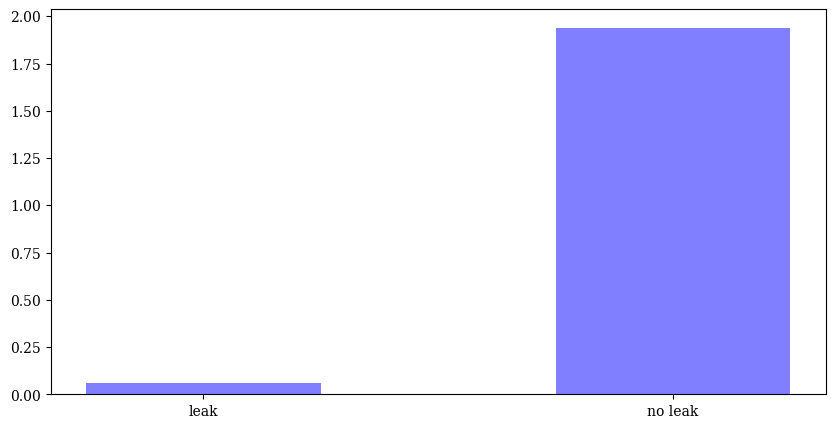

In [27]:
i_sample = 14

test_out = var_post_info['guide'].sample(data_test[i_sample:i_sample+1, [design_dicts[d]['index'] for d in design]], n_samples=1000)

fig, ax = plt.subplots(figsize=(10, 5))

n_bins = 2
ax.hist(test_out.flatten().numpy(), bins=n_bins, density=True, label='prior', alpha=0.5, color='blue', align='mid', rwidth=0.5)
ax.set_xticks([0.25, 0.75])
ax.set_xticklabels(['leak', 'no leak'])
 
plt.plot()

In [28]:

    # fig, ax = plt.subplots(1,1,figsize=(10,5))

    # ax.hist(vp_2_nuisance_samples[:int(1e4)], bins=50, density=True, color='k', alpha=0.5, label='vp')
    # ax.hist(vs_2_nuisance_samples[:int(1e4)], bins=50, density=True, color='b', alpha=0.5, label='vs')

    # ax.legend()

    # plt.show()
    
    # prior_samples_computation = torch.cat([
    #     d_nuisance_samples.unsqueeze(1),
    #     vp_1_nuisance_samples.unsqueeze(1),
    #     vp_2_nuisance_samples.unsqueeze(1),
    #     vs_1_nuisance_samples.unsqueeze(1),
    #     vs_2_nuisance_samples.unsqueeze(1),
    #     rho_1_nuisance_samples.unsqueeze(1),
    #     rho_2_nuisance_samples.unsqueeze(1),
    #     ], dim=1
    # ).T.unsqueeze(2).swapaxes(0,1)

In [29]:
prior_samples_computation[2]

tensor([[1022.0578],
        [2274.3970],
        [2964.4292],
        [ 855.1241],
        [2026.3827],
        [2106.4080],
        [2102.4971]])

torch.Size([100000, 7, 1])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


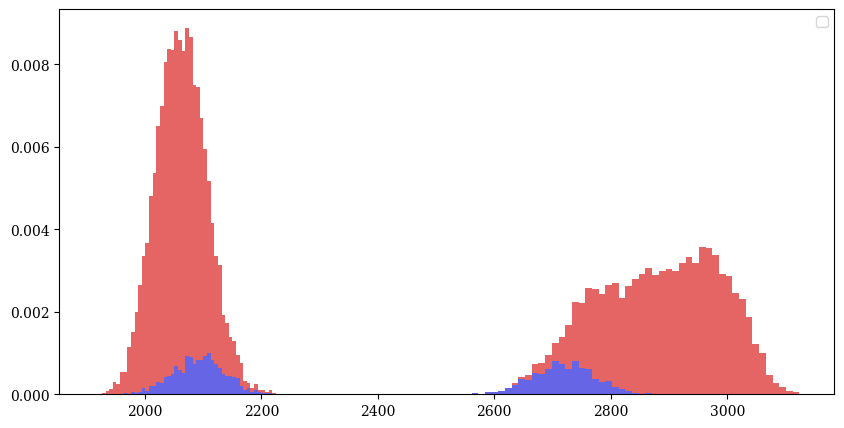

In [30]:
positiv_samples_vp = torch.where(co2_saturations_prior_samples < 0.9, torch.tensor([torch.nan]), prior_samples_computation[:, 2])
negative_samples_vp = torch.where(co2_saturations_prior_samples > 0.9, torch.tensor([torch.nan]), prior_samples_computation[:, 2])

positiv_samples_vs = torch.where(co2_saturations_prior_samples < 0.9, torch.tensor([torch.nan]), prior_samples_computation[:, 4])
negative_samples_vs = torch.where(co2_saturations_prior_samples > 0.9, torch.tensor([torch.nan]), prior_samples_computation[:, 4])

print(prior_samples_computation.shape)
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.hist(prior_samples_computation[:int(1e4), 2, 0], bins=50, density=True, color='k', alpha=0.2)
ax.hist(prior_samples_computation[:int(1e4), 4, 0], bins=50, density=True, color='k', alpha=0.2)

ax.hist([positiv_samples_vp[:int(1e4), 0], negative_samples_vp[:int(1e4), 0]],
        bins=50, density=True, color=['b', 'r'], alpha=0.5,
        histtype='barstacked')

ax.hist([positiv_samples_vs[:int(1e4), 0], negative_samples_vs[:int(1e4), 0]],
        bins=50, density=True, color=['b', 'r'], alpha=0.5,
        histtype='barstacked')

ax.legend()

plt.show()



In [31]:
optimal_design_dict = {}
info_dict = {}

design_budget = 2
n_parallel = 20

In [32]:
# plt.figure(figsize=(20, 5))
# plt.plot(offsets, info_dict[method][1]['eig'], label='eig')
# plt.show()

In [33]:
from geobed.guides import MDN_guide

method = 'variational_posterior'

T = int(1e5)

N = int(T * 0.2)
M = int(T * 0.8)

n_grad_steps = 5000

def n_batch_schedule(M, **kwargs):
    return 10

def n_epochs_schedule(M, n_batch, **kwargs):
    return max(min(50, (n_grad_steps*n_batch)//(M)), 4)

def scheduler_step_size_schedule(n_epochs, **kwargs):
    return n_epochs//3

n_batch = n_batch_schedule(**{'M':M})
n_epochs = n_epochs_schedule(**{'M':M, 'n_batch':n_batch})
step_size = scheduler_step_size_schedule(**{'n_epochs':n_epochs})
print(n_batch, n_epochs, step_size)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau

optimal_design_dict[method], info_dict[method] = BED_class.find_optimal_design(
    design_point_names=design_names,
    design_budget=design_budget,
    eig_method=method,
    eig_method_kwargs=
    {'guide': BM_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'hidden_features':[20, 20], 'normalize':True,},
     'n_batch': n_batch_schedule,
     'n_epochs': n_epochs_schedule,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-3},
     'scheduler': torch.optim.lr_scheduler.StepLR,
     'scheduler_kwargs': {'step_size':scheduler_step_size_schedule, 'gamma':0.3},
     'return_guide': False,
     'return_train_loss': True,
     'return_test_loss': True,
     'progress_bar': False,
     'interrogation_mapping': interrogation_mapping,
     },
    opt_method='iterative_construction',
    opt_method_kwargs={},
    num_workers=n_parallel,
    filename=f'data/{filename_core}_bed_{method}.pkl',
)

10 4 1


  0%|          | 0/2 [00:00<?, ?it/s]

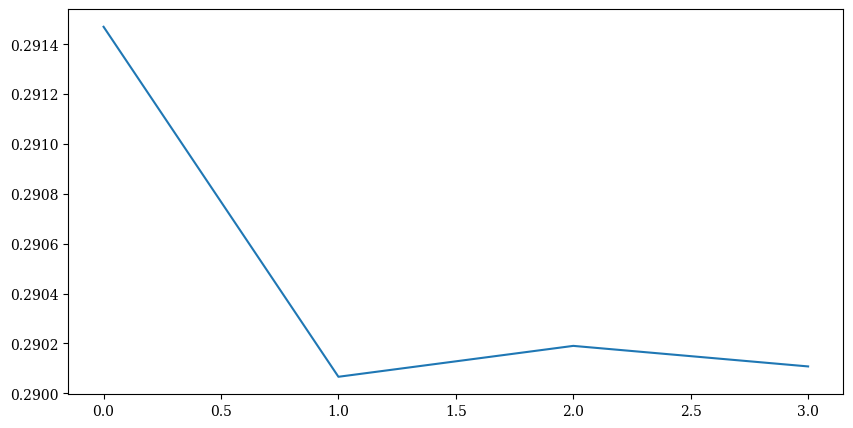

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(info_dict['variational_posterior'][1]['info'][0]['test_loss'], label='train loss')
plt.show()

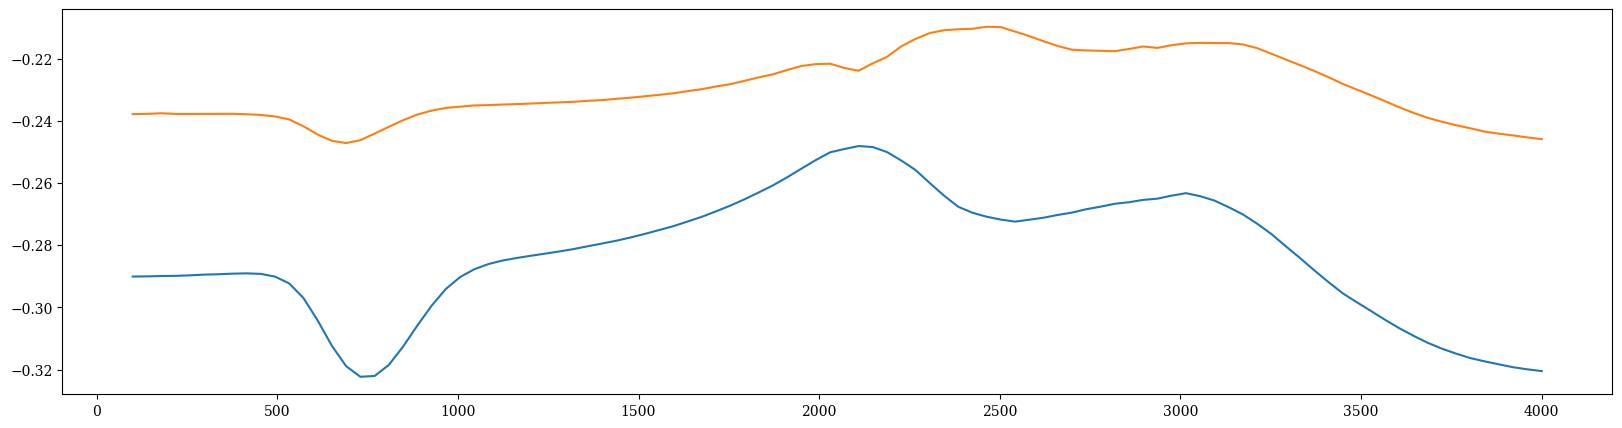

In [35]:
plt.figure(figsize=(20, 5))
plt.plot(offsets, info_dict['variational_posterior'][1]['eig'], label='eig')
plt.plot(offsets, info_dict['variational_posterior'][2]['eig'], label='eig')
plt.show()

In [36]:
n_rec = 2

# nmc_design = optimal_design_dict['nmc'][:n_rec]
variational_posterior_design = optimal_design_dict['variational_posterior'][:n_rec]

# nmc_design_offsets = torch.tensor([design_dicts[d]['offset'] for d in nmc_design])
variational_posterior_design_offsets = torch.tensor([design_dicts[d]['offset'] for d in variational_posterior_design])

if n_rec > 2:
    heuristic_design_offsets = torch.linspace(1000, 3000, n_rec)
elif n_rec == 2:
    heuristic_design_offsets = torch.tensor([1666, 2333])
elif n_rec == 1:
    heuristic_design_offsets = torch.tensor([2000])

heuristic_design = [str(np.argmin(np.abs(offsets - o)).item()) for o in heuristic_design_offsets]

optimal_designs = [
    # nmc_design,
    variational_posterior_design,
    heuristic_design,
]
    
print(optimal_designs) 

optimal_designs_offsets = torch.stack(
    [
    #  nmc_design_offsets,
     variational_posterior_design_offsets,
     heuristic_design_offsets,
     ],
    dim=0,
    ).float().numpy()

print(optimal_designs_offsets)

[['51', '60'], ['36', '61']]
[[2109.091  2463.6362]
 [1500.     2500.    ]]


(0.0, 3.0)

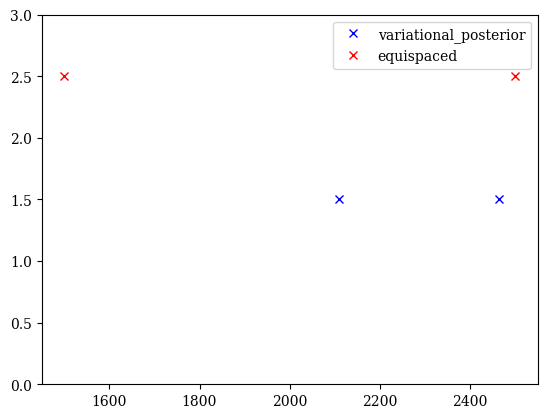

In [37]:
# plt.plot(nmc_design_offsets, 0.5*np.ones(n_rec), 'kx', label='nmc',)
plt.plot(variational_posterior_design_offsets, 1.5*np.ones(n_rec), 'bx', label='variational_posterior',)
plt.plot(heuristic_design_offsets, 2.5*np.ones(n_rec), 'rx', label='equispaced')

plt.legend()

plt.ylim(0, 3)

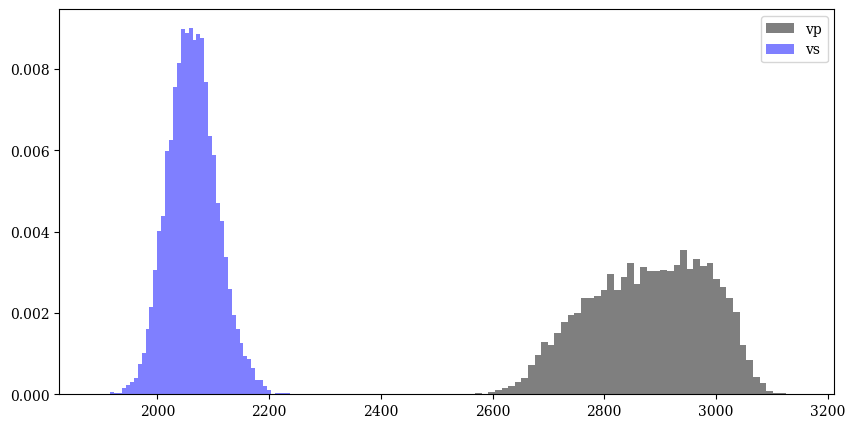

torch.Size([1000000, 7, 1])


In [38]:
n_prior_samples_benchmark = int(1e6)

torch.manual_seed(1)
nuisance_samples_benchmark = nuisance_dist.sample((n_prior_samples_benchmark,))
co2_saturations_prior_samples_benchmark = co2_saturations_prior_dist.sample((n_prior_samples_benchmark,))

prior_samples_computation_benchmark = get_compute_samples(co2_saturations_prior_samples_benchmark, nuisance_samples_benchmark)

print(prior_samples_computation_benchmark.shape)

In [39]:
design_dicts_benchmark = {}

filename_benchmark = f"data/{filename_core}_benchmark_{n_prior_samples_benchmark}_{n_design_points}.h5"

for i, name in enumerate(design_names):
    design_dicts_benchmark[name] = {'index': i, 'offset': offsets[i], 'file': filename_benchmark, 'dataset': 'data', 'cost': 1.0,}

In [40]:
prior_samples_computation_benchmark = generate_lookup_table(
    filename_benchmark,
    prior_samples_computation_benchmark,
    offsets,
    forward_function,
    transpose_order=(2, 0, 1),
    n_parallel = 20)

generating lookup table
starting parallel processing


  0%|          | 0/100 [00:00<?, ?it/s]

dimensions: (n_prior, n_design, data_dim)
(1000000, 100, 1) float32 

100000000
0


In [41]:
from geobed import BED_discrete

BED_class_benchmark = BED_discrete(design_dicts_benchmark, data_likelihood, prior_samples=co2_saturations_prior_samples_benchmark,
                         design2data='lookup_1to1_fast')

No prior distribution given. Variational posterior will only be accurate up to a constant.
                   This is fine for the optimisation but just a heads up.
No prior distribution defined. Setting prior entropy to 0. This has no effect on the design optimisation.


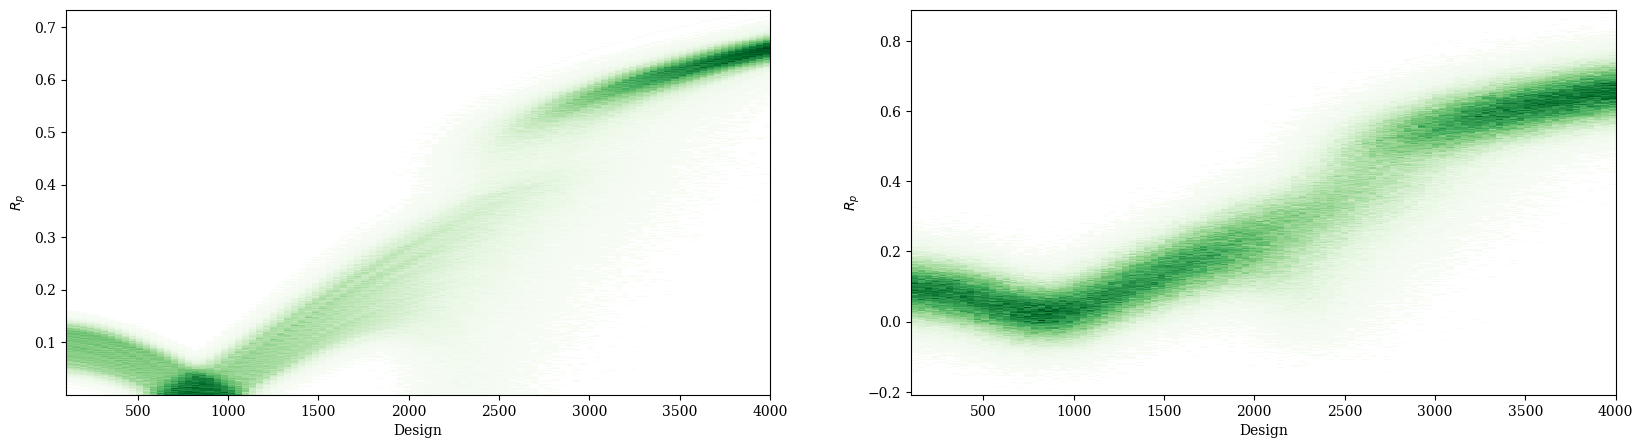

In [42]:
n_visual = int(1e4)

clean_samples = BED_class_benchmark.get_forward_samples(   design_names, n_samples=n_visual)
noisy_samples = BED_class_benchmark.get_likelihood_samples(design_names, n_samples=n_visual)

offsets = torch.tensor([d['offset'] for d in design_dicts.values()])

fig = plt.figure(figsize=(20, 5))
ax_dict = fig.subplot_mosaic('''ab''')

ax_dict['a'].hist2d(offsets.expand(n_visual, -1).flatten().numpy(), clean_samples.flatten().numpy(),
                    bins=[n_design_points, 400], cmap='Greens', cmin=1)

ax_dict['b'].hist2d(offsets.expand(n_visual, -1).flatten().numpy(), noisy_samples.flatten().numpy(),
                    bins=[n_design_points, 400], cmap='Greens', cmin=1)
    
ax_dict['a'].set(xlabel='Design', ylabel=r'$R_p$')
ax_dict['b'].set(xlabel='Design', ylabel=r'$R_p$')
                
plt.show()

In [43]:
from geobed.guides import MDN_guide

method = 'variational_posterior'

T = int(1e5)

N = int(T * 0.2)
M = int(T * 0.8)

n_grad_steps = 10000

def n_batch_schedule(M, **kwargs):
    return 10

def n_epochs_schedule(M, n_batch, **kwargs):
    return max(min(200, (n_grad_steps*n_batch)//(M)), 4)

def scheduler_step_size_schedule(n_epochs, **kwargs):
    return n_epochs//3

n_batch = n_batch_schedule(**{'M':M})
n_epochs = n_epochs_schedule(**{'M':M, 'n_batch':n_batch})
step_size = scheduler_step_size_schedule(**{'n_epochs':n_epochs})
print(n_batch, n_epochs, step_size)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau

optimal_design_benchmark, info_benchmark = BED_class_benchmark.calculate_eig_list(
    design_list=optimal_designs,
    method=method,
    method_kwargs=
    {'guide': BM_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'hidden_features':[20, 20], 'normalize':True,},
     'n_batch': n_batch_schedule,
     'n_epochs': n_epochs_schedule,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-3},
     'scheduler': torch.optim.lr_scheduler.StepLR,
     'scheduler_kwargs': {'step_size':scheduler_step_size_schedule, 'gamma':0.3},
     'return_guide': False,
     'return_train_loss': True,
     'return_test_loss': True,
     'progress_bar': True,
     'interrogation_mapping': interrogation_mapping,
     },
    num_workers=len(optimal_designs),
    filename=f'data/{filename_core}_bed_benchmark.pkl',
)

10 4 1


Epoch 4/4, Loss: 0.216: 100%|██████████| 4/4 [00:44<00:00, 11.01s/it]


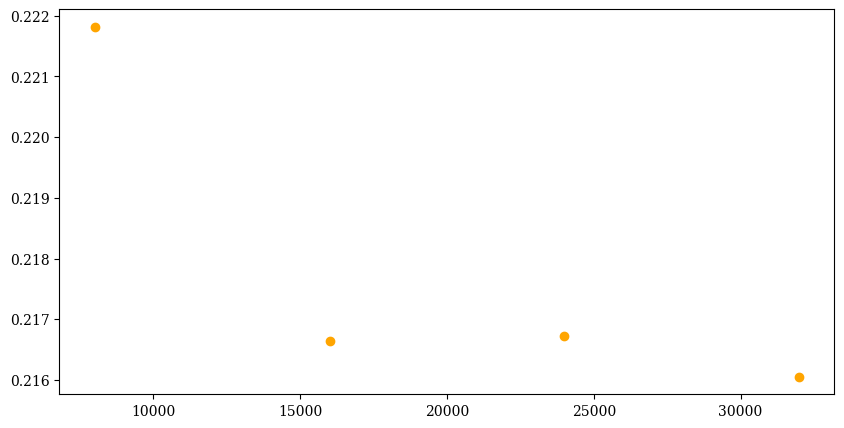

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))

# ax.plot(np.arange(0, n_epochs*M/n_batch, 1), info_benchmark[0]['train_loss'], label='train_loss', color='grey', alpha=0.5)
ax.plot(np.arange(M/n_batch, (n_epochs+1)*M/n_batch, M/n_batch), info_benchmark[0]['test_loss'], 'o', label='test_loss', color='orange')

plt.show()

In [45]:
variational_posterior_design_eig, heuristic_design_eig = optimal_design_benchmark.tolist()

print('variational_posterior_eig:', f'{variational_posterior_design_eig:.2f}')
print('heuristic_eig:', f'{heuristic_design_eig:.2f}')

variational_posterior_eig: -0.22
heuristic_eig: -0.24


In [46]:
import random

n_random_designs = int(1000)

random_design_list = [random.sample(design_names, n_rec) for i in range(n_random_designs)]

print(np.array(random_design_list).shape)

(1000, 2)


In [47]:
random_designs_benchmark, info_random_designs_benchmark = BED_class_benchmark.calculate_eig_list(
    design_list=random_design_list,
    method=method,
    method_kwargs=
    {'guide': BM_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'hidden_features':[20, 20], 'normalize':True,},
     'n_batch': n_batch_schedule,
     'n_epochs': n_epochs_schedule,
    #  'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-3},
     'scheduler': torch.optim.lr_scheduler.StepLR,
     'scheduler_kwargs': {'step_size':scheduler_step_size_schedule, 'gamma':0.3},
     'return_guide': False,
     'return_train_loss': True,
     'return_test_loss': True,
     'progress_bar': False,
     'interrogation_mapping': interrogation_mapping,
     },
    num_workers=n_parallel,
    filename=f'data/{filename_core}_bed_benchmark_random_designs.pkl',
    progress_bar=True,
)

Calculating eig:   0%|          | 0/1000 [00:00<?, ?it/s]

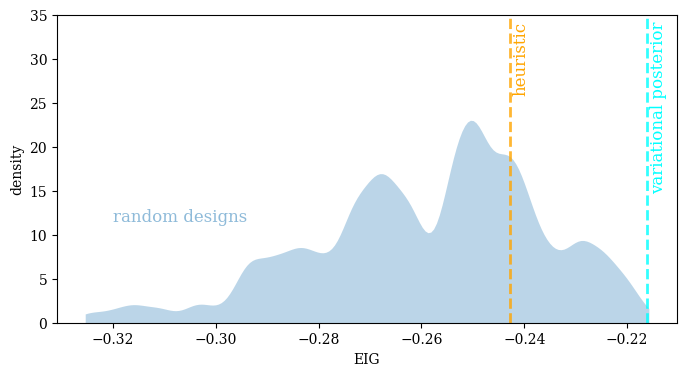

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# ax.hist(random_eig, bins=40, density=True, label='random designs', range=(0.9, 1.4), alpha=0.5)
sns.kdeplot(random_designs_benchmark, ax=ax, label='random designs', 
            color='tab:blue', linewidth=0, alpha=0.3, bw_adjust=0.4, cut=0,
            fill=True)

# ax.set_xlim([-0.33, -0.22])
ax.set_ylim([0, 35.0])
vertical_offset = ax.get_ylim()[1] * 0.98

fontsize = 12
ymin = 0.0
lw=2.0

# ax.axvline(nmc_design_eig, ymin=ymin, color='k' , linewidth=lw, linestyle='--', alpha=0.8, zorder=1,)
# ax.text(nmc_design_eig+0.005, vertical_offset, 'NMC', rotation=90, color='k', fontsize=fontsize, verticalalignment='top')

ax.axvline(variational_posterior_design_eig, ymin=ymin, color='cyan', linewidth=lw, linestyle='--', alpha=0.8, zorder=1,)
ax.text(variational_posterior_design_eig+0.0005, vertical_offset, 'variational posterior', rotation=90, color='cyan', fontsize=fontsize, verticalalignment='top')

ax.axvline(heuristic_design_eig, ymin=ymin, color='orange', linewidth=lw, linestyle='--', alpha=0.8, zorder=1,)
ax.text(heuristic_design_eig+0.0005, vertical_offset, 'heuristic', rotation=90, color='orange', fontsize=fontsize, verticalalignment='top')

ax.text(-0.32, vertical_offset*0.35, 'random designs', rotation=0, color='tab:blue',
        fontsize=fontsize, verticalalignment='center', alpha=0.5, )

# ax.set_xticks(np.arange(-0.33, -0.21, 0.02))
# ax.set_xticklabels(['' for x in ax.get_xticks()], fontsize=fontsize)

fig.savefig('figures/interrogation/interrogation_uniform_eig_comparison_interrogation_90.pdf', bbox_inches='tight', transparent=True, dpi=150)
fig.savefig('figures/interrogation/interrogation_uniform_eig_comparison_interrogation_90.png', bbox_inches='tight', transparent=True, dpi=150)

ax.set_xlabel('EIG')
ax.set_ylabel('density')

plt.show()